In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

REACTION_FRAMES = 6
HZ = 10
AIRY_MIN, AIRY_MAX = 5, 25
MIN_DIST_RELEASE = 5
YAC_CAP = 30
EXP_YAC_THRESH = 10
MIN_FRAMES_USED = 3

TRAIN_DIR = "../data/train"
SUPP_PATH = "../data/supplementary_data.csv"



In [11]:
def _require_cols(df, cols, name):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{name} missing columns: {missing}")

def _attach_supp_fields(df, supp_df):
    fields = [
        "game_id","play_id","week","game_date",
        "home_team_abbr","visitor_team_abbr",
        "quarter","game_clock","play_description"
    ]
    keep = [c for c in fields if c in supp_df.columns]
    return df.merge(
        supp_df[keep].drop_duplicates(["game_id","play_id"]),
        on=["game_id","play_id"],
        how="left"
    )

def _print_week_counts(df, label):
    vc = df["week"].value_counts(dropna=False).sort_index()
    print(f"\n[{label}] week distribution:")
    print(vc)


In [12]:
supp_df = pd.read_csv(SUPP_PATH, low_memory=False)

input_files = sorted(glob.glob(f"{TRAIN_DIR}/input_2023_w*.csv"))
output_files = sorted(glob.glob(f"{TRAIN_DIR}/output_2023_w*.csv"))

input_df = pd.concat([pd.read_csv(f) for f in input_files], ignore_index=True)
output_df = pd.concat([pd.read_csv(f) for f in output_files], ignore_index=True)

input_df["frame_id"] = pd.to_numeric(input_df["frame_id"], errors="coerce")
output_df["frame_id"] = pd.to_numeric(output_df["frame_id"], errors="coerce")

print("Loaded input:", input_df.shape)
print("Loaded output:", output_df.shape)


Loaded input: (4880579, 23)
Loaded output: (562936, 6)


In [13]:
# ============================================================
# 2) Build play2 (play-level) from supplementary
# ============================================================
_require_cols(supp_df, ["game_id","play_id","pass_length","yards_gained","pass_result","week"], "supp_df")

play2 = (
    supp_df[["game_id","play_id","pass_length","yards_gained","pass_result"]]
    .drop_duplicates(["game_id","play_id"])
    .copy()
)
play2["completed"] = (play2["pass_result"].astype(str).str.upper() == "C")
play2["intercepted"] = (play2["pass_result"].astype(str).str.upper() == "IN")  # not used in filters
print("Built play2:", play2.shape)

# sanity: weeks covered by input_df plays
input_plays = input_df[["game_id","play_id"]].drop_duplicates()
input_plays = input_plays.merge(supp_df[["game_id","play_id","week"]], on=["game_id","play_id"], how="left")
_print_week_counts(input_plays, "Plays present in input_df (via supp_df)")

# ============================================================
# 3) Guardrails
# ============================================================
_require_cols(play2, ["game_id","play_id","pass_length","yards_gained","completed"], "play2")
_require_cols(input_df, ["game_id","play_id","nfl_id","frame_id","x","y","player_role","player_side","player_position"], "input_df")
_require_cols(output_df, ["game_id","play_id","nfl_id","frame_id","x","y"], "output_df")

# ============================================================
# 4) Targeted receiver @ release (last input frame where player_role == Targeted Receiver)
# ============================================================
tr = input_df.loc[
    input_df["player_role"] == "Targeted Receiver",
    ["game_id","play_id","nfl_id","frame_id","x","y"]
].copy()

tr = tr.sort_values(["game_id","play_id","frame_id"])
tr_last = tr.groupby(["game_id","play_id"], as_index=False).tail(1).copy()

tr_last = tr_last.rename(columns={
    "nfl_id": "tr_nfl_id",
    "frame_id": "release_frame_in",
    "x": "tr_x_release",
    "y": "tr_y_release"
})

print("Targeted-receiver plays (tr_last):", tr_last.shape[0])

# ============================================================
# 5) Closest safety at release + dist_release
# ============================================================
safety_mask = (
    input_df["player_side"].astype(str).str.lower().str.startswith("def")
    & input_df["player_position"].astype(str).str.upper().str.contains("S", na=False)
)

saf = input_df.loc[safety_mask, ["game_id","play_id","nfl_id","frame_id","x","y"]].copy()
saf = saf.rename(columns={
    "nfl_id": "s_nfl_id",
    "x": "s_x_release",
    "y": "s_y_release",
    "frame_id": "frame_in"
})

saf_at_release = saf.merge(
    tr_last[["game_id","play_id","release_frame_in","tr_x_release","tr_y_release"]],
    on=["game_id","play_id"],
    how="inner"
)

saf_at_release = saf_at_release[saf_at_release["frame_in"] == saf_at_release["release_frame_in"]].copy()

saf_at_release["dist_release"] = np.sqrt(
    (saf_at_release["s_x_release"] - saf_at_release["tr_x_release"])**2 +
    (saf_at_release["s_y_release"] - saf_at_release["tr_y_release"])**2
)

saf_closest = (
    saf_at_release.sort_values(["game_id","play_id","dist_release"])
    .groupby(["game_id","play_id"], as_index=False)
    .head(1)
    .copy()
)

print("Plays with a closest safety at release:", saf_closest.shape[0])

# ============================================================
# 6) Early post-release closing speed (yards/sec) using output_df
# ============================================================
out = output_df.rename(columns={
    "nfl_id": "s_nfl_id",
    "frame_id": "out_frame",
    "x": "s_x",
    "y": "s_y"
}).copy()

out_s = (
    out.merge(
        saf_closest[["game_id","play_id","s_nfl_id","tr_x_release","tr_y_release"]],
        on=["game_id","play_id","s_nfl_id"],
        how="inner"
    )
    .sort_values(["game_id","play_id","out_frame"])
)

print("Rows of safety tracking in output window candidate set:", out_s.shape[0])

first_out = (
    out_s.groupby(["game_id","play_id"], as_index=False)
    .head(1)[["game_id","play_id","out_frame"]]
    .rename(columns={"out_frame": "frame0"})
)

win = out_s.merge(first_out, on=["game_id","play_id"], how="inner")
win["max_frame"] = win["frame0"] + REACTION_FRAMES
win = win[(win["out_frame"] >= win["frame0"]) & (win["out_frame"] <= win["max_frame"])].copy()

# pos0 at frame0
pos0 = win[win["out_frame"] == win["frame0"]][
    ["game_id","play_id","out_frame","s_x","s_y","tr_x_release","tr_y_release"]
].rename(columns={"out_frame":"frame0","s_x":"s_x0","s_y":"s_y0"})

# posN at last available frame in window
last_frame = (
    win.groupby(["game_id","play_id"], as_index=False)["out_frame"]
    .max()
    .rename(columns={"out_frame": "frameN"})
)

posN = win.merge(last_frame, on=["game_id","play_id"], how="inner")
posN = posN[posN["out_frame"] == posN["frameN"]][
    ["game_id","play_id","out_frame","s_x","s_y"]
].rename(columns={"out_frame":"frameN","s_x":"s_xN","s_y":"s_yN"})

closing = pos0.merge(posN, on=["game_id","play_id"], how="inner")

closing["frames_used"] = (closing["frameN"] - closing["frame0"]).astype(int)
closing["dt_sec"] = closing["frames_used"] / HZ

# distance to receiver RELEASE position (anchor)
closing["d0"] = np.sqrt(
    (closing["s_x0"] - closing["tr_x_release"])**2 +
    (closing["s_y0"] - closing["tr_y_release"])**2
)
closing["dN"] = np.sqrt(
    (closing["s_xN"] - closing["tr_x_release"])**2 +
    (closing["s_yN"] - closing["tr_y_release"])**2
)

closing = closing[(closing["dt_sec"] > 0) & (closing["frames_used"] >= MIN_FRAMES_USED)].copy()
closing["closing_speed_yps"] = (closing["d0"] - closing["dN"]) / closing["dt_sec"]

print("Plays with computed closing_speed_yps:", closing.shape[0])

# ============================================================
# 7) Merge to play2 + outcomes + filters + attach week
# ============================================================
df = (
    play2.merge(
        saf_closest[["game_id","play_id","dist_release"]],
        on=["game_id","play_id"],
        how="left"
    )
    .merge(
        closing[["game_id","play_id","closing_speed_yps","frames_used","dt_sec"]],
        on=["game_id","play_id"],
        how="left"
    )
    .copy()
)

df["air_yards"] = df["pass_length"]
df["yac"] = (df["yards_gained"] - df["air_yards"]).clip(lower=0)
df["yac_w"] = df["yac"].clip(upper=YAC_CAP)
df["explosive_yac"] = (df["yac"] >= EXP_YAC_THRESH).astype(int)

df = _attach_supp_fields(df, supp_df)
_print_week_counts(df, "df BEFORE filters")

df = df[
    (df["completed"] == True) &
    (df["air_yards"].between(AIRY_MIN, AIRY_MAX, inclusive="both")) &
    (df["dist_release"] >= MIN_DIST_RELEASE) &
    (df["closing_speed_yps"].notna())
].copy()

print("\nFINAL SAMPLE SIZE:", len(df))
_print_week_counts(df, "df AFTER filters")


Built play2: (18009, 7)

[Plays present in input_df (via supp_df)] week distribution:
week
1     819
2     850
3     904
4     779
5     742
6     793
7     693
8     827
9     711
10    721
11    707
12    854
13    666
14    796
15    791
16    896
17    809
18    750
Name: count, dtype: int64
Targeted-receiver plays (tr_last): 14108
Plays with a closest safety at release: 14062
Rows of safety tracking in output window candidate set: 92320
Plays with computed closing_speed_yps: 7028

[df BEFORE filters] week distribution:
week
1      819
2      850
3      904
4      779
5      742
6      793
7      693
8      827
9      711
10     721
11     707
12     854
13     666
14    1460
15    1594
16    1686
17    1603
18    1600
Name: count, dtype: int64

FINAL SAMPLE SIZE: 2189

[df AFTER filters] week distribution:
week
1     133
2     149
3     146
4     117
5     115
6      97
7     106
8     127
9     118
10    112
11    109
12    133
13    108
14    113
15    147
16    141
17    113
18

In [14]:
# ============================================================
# 8) Terciles (slow/medium/fast)
# ============================================================
q33, q67 = df["closing_speed_yps"].quantile([1/3, 2/3]).values

def _tier(v):
    if v <= q33:
        return "slow"
    elif v <= q67:
        return "medium"
    else:
        return "fast"

df["react_tier"] = df["closing_speed_yps"].apply(_tier)

print("Tercile cutoffs:")
print(" q33 =", round(q33, 3), "yd/s")
print(" q67 =", round(q67, 3), "yd/s")

tier_summary = (
    df.groupby("react_tier")
      .agg(
          n=("explosive_yac","size"),
          explosive_rate=("explosive_yac","mean"),
          mean_yac_w=("yac_w","mean"),
          median_yac_w=("yac_w","median"),
          mean_closing_speed=("closing_speed_yps","mean"),
          median_dist_release=("dist_release","median"),
          mean_frames_used=("frames_used","mean"),
          mean_dt_sec=("dt_sec","mean"),
      )
      .reset_index()
)

tier_summary["explosive_rate"] = (tier_summary["explosive_rate"] * 100).round(2)
tier_summary["react_tier"] = pd.Categorical(tier_summary["react_tier"], ["slow","medium","fast"], ordered=True)
tier_summary = tier_summary.sort_values("react_tier")

display(tier_summary)


Tercile cutoffs:
 q33 = -1.662 yd/s
 q67 = 1.215 yd/s


,react_tier,n,explosive_rate,mean_yac_w,median_yac_w,mean_closing_speed,median_dist_release,mean_frames_used,mean_dt_sec
2,slow,730,13.84,4.463014,2.0,-3.647544,9.386570,5.994521,0.599452
1,medium,729,9.88,3.491084,2.0,-0.195030,9.077957,5.994513,0.599451
0,fast,730,6.99,2.669863,1.0,3.194679,8.941098,5.982192,0.598219


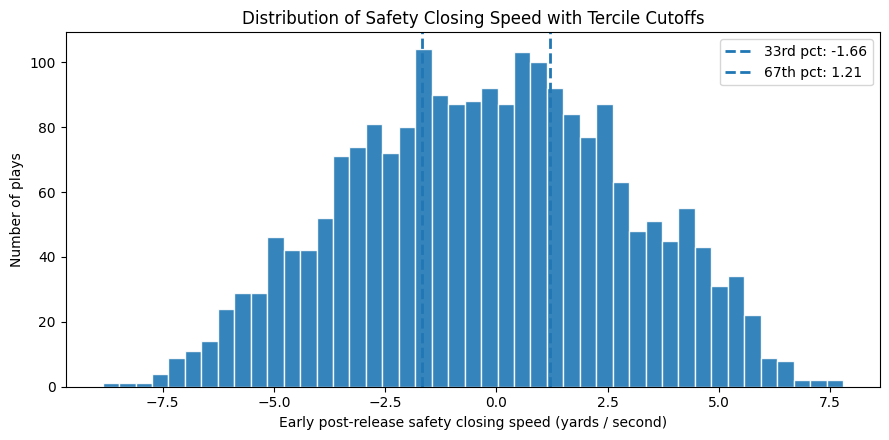

Saved: closing_speed_distribution_terciles.png


In [15]:
x = df["closing_speed_yps"].dropna()

plt.figure(figsize=(9, 4.5))
plt.hist(x, bins=45, edgecolor="white", alpha=0.9)
plt.axvline(q33, linestyle="--", linewidth=2, label=f"33rd pct: {q33:.2f}")
plt.axvline(q67, linestyle="--", linewidth=2, label=f"67th pct: {q67:.2f}")
plt.xlabel("Early post-release safety closing speed (yards / second)")
plt.ylabel("Number of plays")
plt.title("Distribution of Safety Closing Speed with Tercile Cutoffs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4.5))
plt.hist(x, bins=45, edgecolor="white", alpha=0.9)
plt.axvline(q33, linestyle="--", linewidth=2, label=f"33rd pct: {q33:.2f}")
plt.axvline(q67, linestyle="--", linewidth=2, label=f"67th pct: {q67:.2f}")
plt.xlabel("Early post-release safety closing speed (yards / second)")
plt.ylabel("Number of plays")
plt.title("Distribution of Safety Closing Speed with Tercile Cutoffs")
plt.legend()
plt.tight_layout()
plt.savefig("closing_speed_distribution_terciles.png", dpi=200, bbox_inches="tight")
plt.close()
print("Saved: closing_speed_distribution_terciles.png")


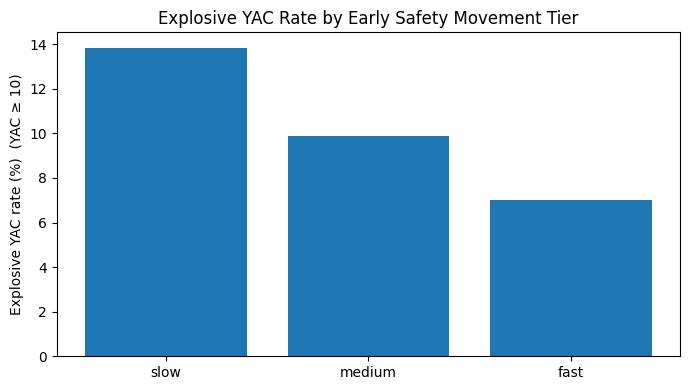

Saved: explosive_rate_by_tier.png


In [16]:
plt.figure(figsize=(7, 4))
plt.bar(tier_summary["react_tier"].astype(str), tier_summary["explosive_rate"])
plt.ylabel("Explosive YAC rate (%)  (YAC ≥ 10)")
plt.title("Explosive YAC Rate by Early Safety Movement Tier")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.bar(tier_summary["react_tier"].astype(str), tier_summary["explosive_rate"])
plt.ylabel("Explosive YAC rate (%)  (YAC ≥ 10)")
plt.title("Explosive YAC Rate by Early Safety Movement Tier")
plt.tight_layout()
plt.savefig("explosive_rate_by_tier.png", dpi=200, bbox_inches="tight")
plt.close()
print("Saved: explosive_rate_by_tier.png")


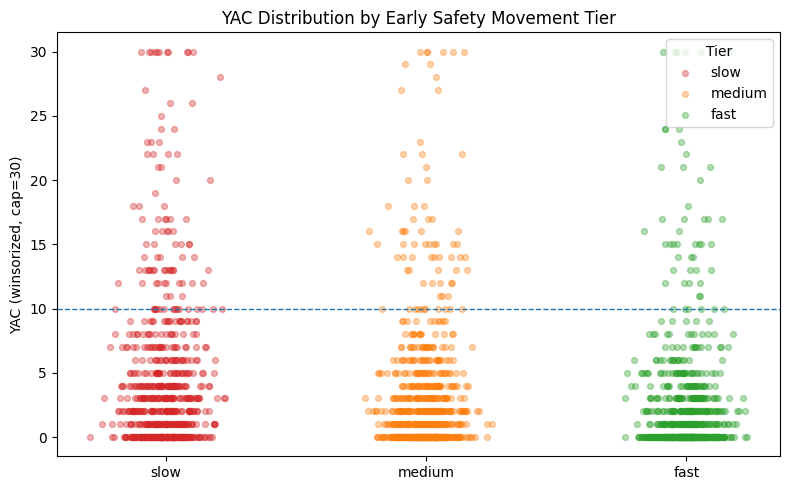

Saved: yac_distribution_by_tier.png


In [17]:
import numpy as np

df_plot = df[["react_tier","yac_w"]].dropna().copy()
df_plot["react_tier"] = df_plot["react_tier"].astype(str)

order = ["slow","medium","fast"]
tier_to_x = {t:i for i,t in enumerate(order)}
df_plot["x"] = df_plot["react_tier"].map(tier_to_x).astype(float)

rng = np.random.default_rng(42)
df_plot["x_jitter"] = df_plot["x"] + rng.normal(0, 0.08, size=len(df_plot))

colors = {"slow": "#d62728", "medium": "#ff7f0e", "fast": "#2ca02c"}

plt.figure(figsize=(8, 5))
for t in order:
    sub = df_plot[df_plot["react_tier"] == t]
    plt.scatter(sub["x_jitter"], sub["yac_w"], alpha=0.35, s=18, c=colors[t], label=t)

plt.xticks(range(len(order)), order)
plt.axhline(EXP_YAC_THRESH, linestyle="--", linewidth=1)
plt.ylabel("YAC (winsorized, cap=30)")
plt.title("YAC Distribution by Early Safety Movement Tier")
plt.legend(title="Tier")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for t in order:
    sub = df_plot[df_plot["react_tier"] == t]
    plt.scatter(sub["x_jitter"], sub["yac_w"], alpha=0.35, s=18, c=colors[t], label=t)

plt.xticks(range(len(order)), order)
plt.axhline(EXP_YAC_THRESH, linestyle="--", linewidth=1)
plt.ylabel("YAC (winsorized, cap=30)")
plt.title("YAC Distribution by Early Safety Movement Tier")
plt.legend(title="Tier")
plt.tight_layout()
plt.savefig("yac_distribution_by_tier.png", dpi=200, bbox_inches="tight")
plt.close()
print("Saved: yac_distribution_by_tier.png")
